(frailty_models)=
# Frailty and Survival Regression Models

:::{post} January, 2023
:tags: frailty models, survival analysis, competing risks
:category: intermediate, reference
:author: Nathaniel Forde
:::

In [624]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
from matplotlib import cm

In [3]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

In [210]:
retention_df = pd.read_csv('../data/time_to_attrition.csv')

dummies = pd.concat([pd.get_dummies(retention_df['gender'], drop_first=True),
pd.get_dummies(retention_df['level'], drop_first=True),
pd.get_dummies(retention_df['field'], drop_first=True), 
], axis=1)

retention_df = pd.concat([retention_df, dummies], axis=1)
retention_df.head()

gender                   field   level  sentiment  intention  left  month  \
0      M       Public/Government    High          3          8     1      1   
1      F                 Finance     Low          8          4     0     12   
2      M  Education and Training  Medium          7          7     1      5   
3      M                 Finance     Low          8          4     0     12   
4      M                 Finance    High          7          6     1      1   

   M  Low  Medium  Finance  Health  Law  Public/Government  Sales/Marketing  
0  1    0       0        0       0    0                  1                0  
1  0    1       0        1       0    0                  0                0  
2  1    0       1        0       0    0                  0                0  
3  1    1       0        1       0    0                  0                0  
4  1    0       0        1       0    0                  0                0

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/lifelines/plotting.py:964: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


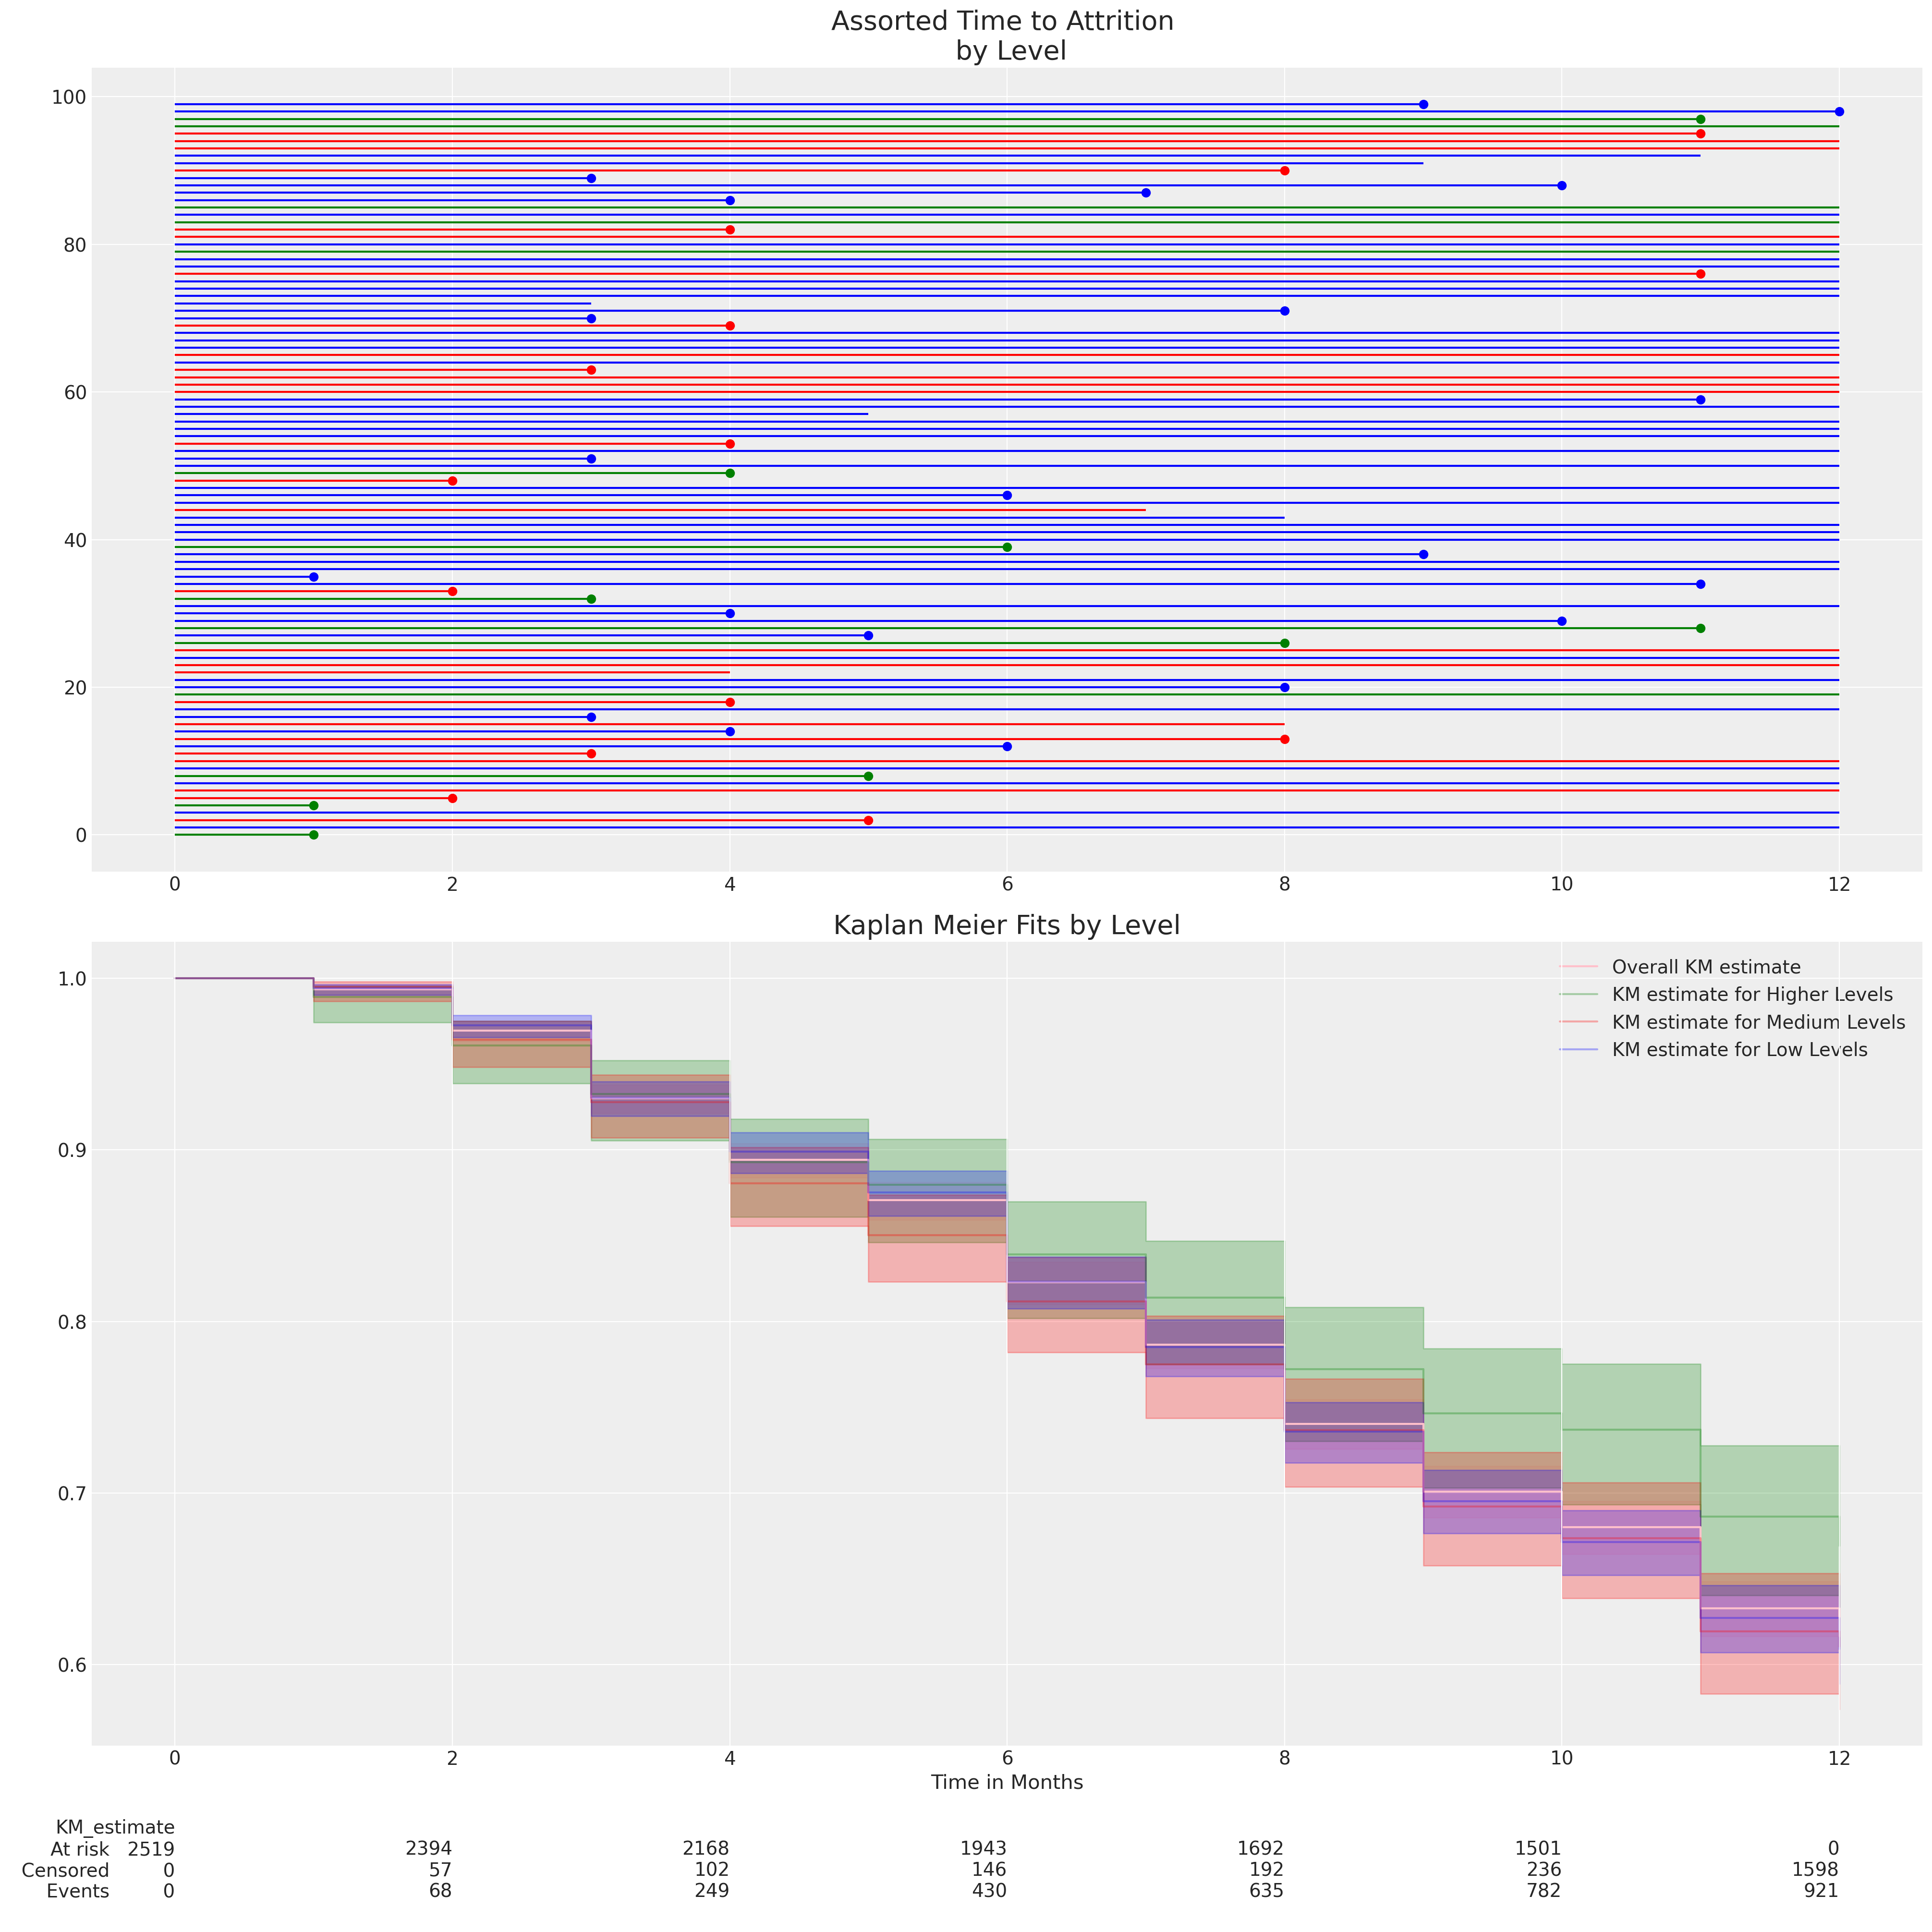

In [662]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(retention_df['month'], event_observed=retention_df['left'])
kmf_hi = KaplanMeierFitter()
kmf_hi.fit(retention_df[retention_df['level']=='High']['month'], event_observed=retention_df[retention_df['level']=='High']['left'])
kmf_mid = KaplanMeierFitter()
kmf_mid.fit(retention_df[retention_df['level']=='Medium']['month'], event_observed=retention_df[retention_df['level']=='Medium']['left'])
kmf_low = KaplanMeierFitter()
kmf_low.fit(retention_df[retention_df['level']=='Low']['month'], event_observed=retention_df[retention_df['level']=='Low']['left'])

fig, axs = plt.subplots(2,1, figsize=(20, 20))
axs = axs.flatten()
ax = axs[0]
for i in retention_df.index.unique()[0:100]:
    temp = retention_df[retention_df.index == i]
    event = temp['left'].max() == 1
    level = temp['level'].unique()
    duration = temp['month'].max()
    color = np.where(level == 'High', 'green', np.where(level == 'Medium', 'red', 'blue'))
    ax.hlines(i, 0, duration, color=color)
    if event: 
        ax.scatter(duration, i, color=color)
ax.set_title("Assorted Time to Attrition \n by Level", fontsize=20)

kmf.plot_survival_function(ax=axs[1], label='Overall KM estimate', color='pink')
kmf_hi.plot_survival_function(ax=axs[1], label='KM estimate for Higher Levels', color='green', alpha=0.3)
kmf_mid.plot_survival_function(ax=axs[1], label='KM estimate for Medium Levels', color='red', alpha=0.3)
kmf_low.plot_survival_function(ax=axs[1], label='KM estimate for Low Levels', color='blue', at_risk_counts=True, alpha=0.3)
axs[1].set_xlabel("Time in Months")
axs[1].set_title("Kaplan Meier Fits by Level", fontsize=20);
    
    

In [399]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(retention_df, duration_col='month', event_col='left', formula="sentiment + intention + gender + level + field")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3770 total observations, 2416 right-censored observations>
             duration col = 'month'
                event col = 'left'
      baseline estimation = breslow
   number of observations = 3770
number of events observed = 1354
   partial log-likelihood = -10613.49
         time fit was run = 2023-10-01 20:03:53 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
sentiment                   -0.03       0.97       0.02            -0.06            -0.00                 0.94                 1.00
intention                    0.21       1.23       0.01             0.18             0.23                 1.20                 1.26
gender[T.M]                  0.02       1.02       0.06            -0.10             0.13                 0.91                 1.14
level[T.Low]                 0.17       1.18       0.09            -0.01             0.34                 0.99                 1.41
level[T.Medium]              0.12       1.12       0.10            -0.08             0.32                 0.92                 1.37
field[T.Finance]             0.25       1.29       0.07             0.12             0.39                 1.13                 1.47
field[T.Health]              0.26       1.30       0.13             0.01             0.51                 1.01                 1.67
field[T.Law]                 0.08       1.09       0.15            -0.20             0.37                 0.82                 1.45
field[T.Public/Government]   0.14       1.14       0.09            -0.04             0.31                 0.96                 1.36
field[T.Sales/Marketing]     0.11       1.12       0.10            -0.09             0.31                 0.91                 1.37

                             cmp to     z      p   -log2(p)
covariate                                                  
sentiment                      0.00 -2.01   0.04       4.50
intention                      0.00 15.23 <0.005     171.48
gender[T.M]                    0.00  0.27   0.79       0.35
level[T.Low]                   0.00  1.85   0.06       3.95
level[T.Medium]                0.00  1.14   0.26       1.97
field[T.Finance]               0.00  3.82 <0.005      12.86
field[T.Health]                0.00  2.02   0.04       4.51
field[T.Law]                   0.00  0.58   0.56       0.83
field[T.Public/Government]     0.00  1.52   0.13       2.96
field[T.Sales/Marketing]       0.00  1.09   0.28       1.86
---
Concordance = 0.64
Partial AIC = 21246.97
log-likelihood ratio test = 311.25 on 10 df
-log2(p) of ll-ratio test = 199.94

In [69]:
interval_length = 1
interval_bounds = np.arange(0, retention_df.month.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)
intervals

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [73]:
intervals = np.arange(12)
n_employees = retention_df.shape[0]
n_intervals =len(intervals)
last_period = np.floor((retention_df.month - 0.01) / interval_length).astype(int)
employees = np.arange(n_employees)
quit = np.zeros((n_employees, n_intervals))
quit[employees, last_period] = retention_df['left']

pd.DataFrame(quit)

0    1    2    3    4    5    6    7    8    9    10   11
0     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
3765  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3766  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
3767  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
3768  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3769  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[3770 rows x 12 columns]

In [72]:
exposure = np.greater_equal.outer(retention_df.month.to_numpy(), interval_bounds[:-2]) * interval_length
exposure[employees, last_period] = retention_df.month - interval_bounds[last_period]
pd.DataFrame(exposure)

0   1   2   3   4   5   6   7   8   9   10  11
0      1   1   0   0   0   0   0   0   0   0   0   0
1      1   1   1   1   1   1   1   1   1   1   1   1
2      1   1   1   1   1   1   0   0   0   0   0   0
3      1   1   1   1   1   1   1   1   1   1   1   1
4      1   1   0   0   0   0   0   0   0   0   0   0
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
3765   1   1   1   1   1   1   1   1   1   1   1   1
3766   1   1   1   1   1   1   1   1   1   0   0   0
3767   1   1   1   1   1   1   1   1   1   0   0   0
3768   1   1   1   1   1   1   1   1   1   1   1   1
3769   1   1   1   1   1   1   1   1   1   1   1   1

[3770 rows x 12 columns]

## Fit Basic Model with Fixed Effects

Sampling: [beta, lambda0, obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


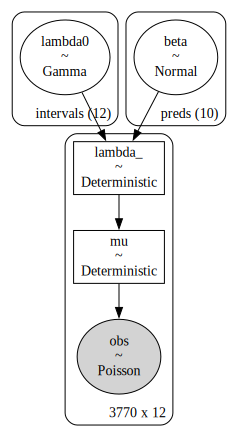

In [336]:
coords = {"intervals": intervals, 
          'preds': ['sentiment', 'intention', 'Male', 'Low', 'Medium', 
                    'Finance', 'Health', 'Law', 'Public/Government', 'Sales/Marketing'
                    ]}

with pm.Model(coords=coords) as base_model:
    lambda0 = pm.Gamma("lambda0", 0.01, 0.01, dims="intervals")

    beta = pm.Normal("beta", 0, sigma=1, dims ='preds')

    lambda_ = pm.Deterministic("lambda_", pt.outer(pt.exp(beta[0]*retention_df['sentiment'] + 
                                                          beta[1]*retention_df['intention'] +
                                                          beta[2]*retention_df['M'] + 
                                                          beta[3]*retention_df['Low'] + 
                                                          beta[4]*retention_df['Medium'] +
                                                          beta[5]*retention_df['Finance'] +
                                                          beta[6]*retention_df['Health'] +
                                                          beta[7]*retention_df['Law'] +
                                                          beta[8]*retention_df['Public/Government'] +
                                                          beta[9]*retention_df['Sales/Marketing']), lambda0))
    
    mu = pm.Deterministic("mu", exposure*lambda_)

    obs = pm.Poisson("obs", mu, observed=quit)
    base_idata = pm.sample_prior_predictive()
    base_idata.extend(pm.sample())

pm.model_to_graphviz(base_model)

## Fit Model with Shared Frailty terms by Individual

Sampling: [beta, frailty, lambda0, obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, frailty, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


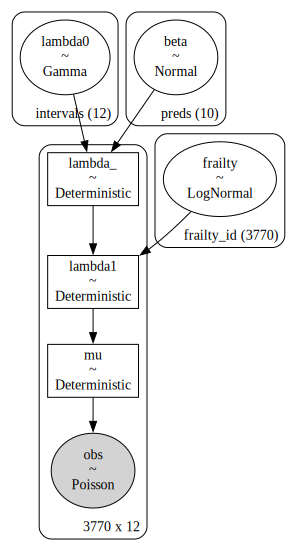

In [454]:
frailty_idx, frailty_labels = pd.factorize(range(len(retention_df)))
coords = {"intervals": intervals, 
          'preds': ['sentiment', 'intention', 'Male', 'Low', 'Medium', 
                    'Finance', 'Health', 'Law', 'Public/Government', 'Sales/Marketing'], 
          "frailty_id": frailty_labels}

with pm.Model(coords=coords) as frailty_model:
    lambda0 = pm.Gamma("lambda0", 0.01, 0.01, dims="intervals")
    frailty = pm.LogNormal('frailty', 0, 0.25, dims='frailty_id')

    beta = pm.Normal("beta", 0, sigma=1, dims ='preds')

    lambda_ = pm.Deterministic("lambda_", pt.outer(pt.exp(beta[0]*retention_df['sentiment'] + 
                                                          beta[1]*retention_df['intention'] +
                                                          beta[2]*retention_df['M'] + 
                                                          beta[3]*retention_df['Low'] + 
                                                          beta[4]*retention_df['Medium'] +
                                                          beta[5]*retention_df['Finance'] +
                                                          beta[6]*retention_df['Health'] +
                                                          beta[7]*retention_df['Law'] +
                                                          beta[8]*retention_df['Public/Government'] +
                                                          beta[9]*retention_df['Sales/Marketing']), lambda0))
    lambda1 = pm.Deterministic('lambda1', frailty[frailty_idx, None]*lambda_)
    
    mu = pm.Deterministic("mu", exposure*lambda1)

    obs = pm.Poisson("obs", mu, observed=quit)
    frailty_idata = pm.sample_prior_predictive()
    frailty_idata.extend(pm.sample())

pm.model_to_graphviz(frailty_model)

## Extract Fitted Hazard Terms

In [361]:
def cum_hazard(hazard):
    return hazard.cumsum(dim='intervals')


def survival(hazard):
    return np.exp(-cum_hazard(hazard))


def get_mean(trace):
    return trace.mean(("draw", "chain"))

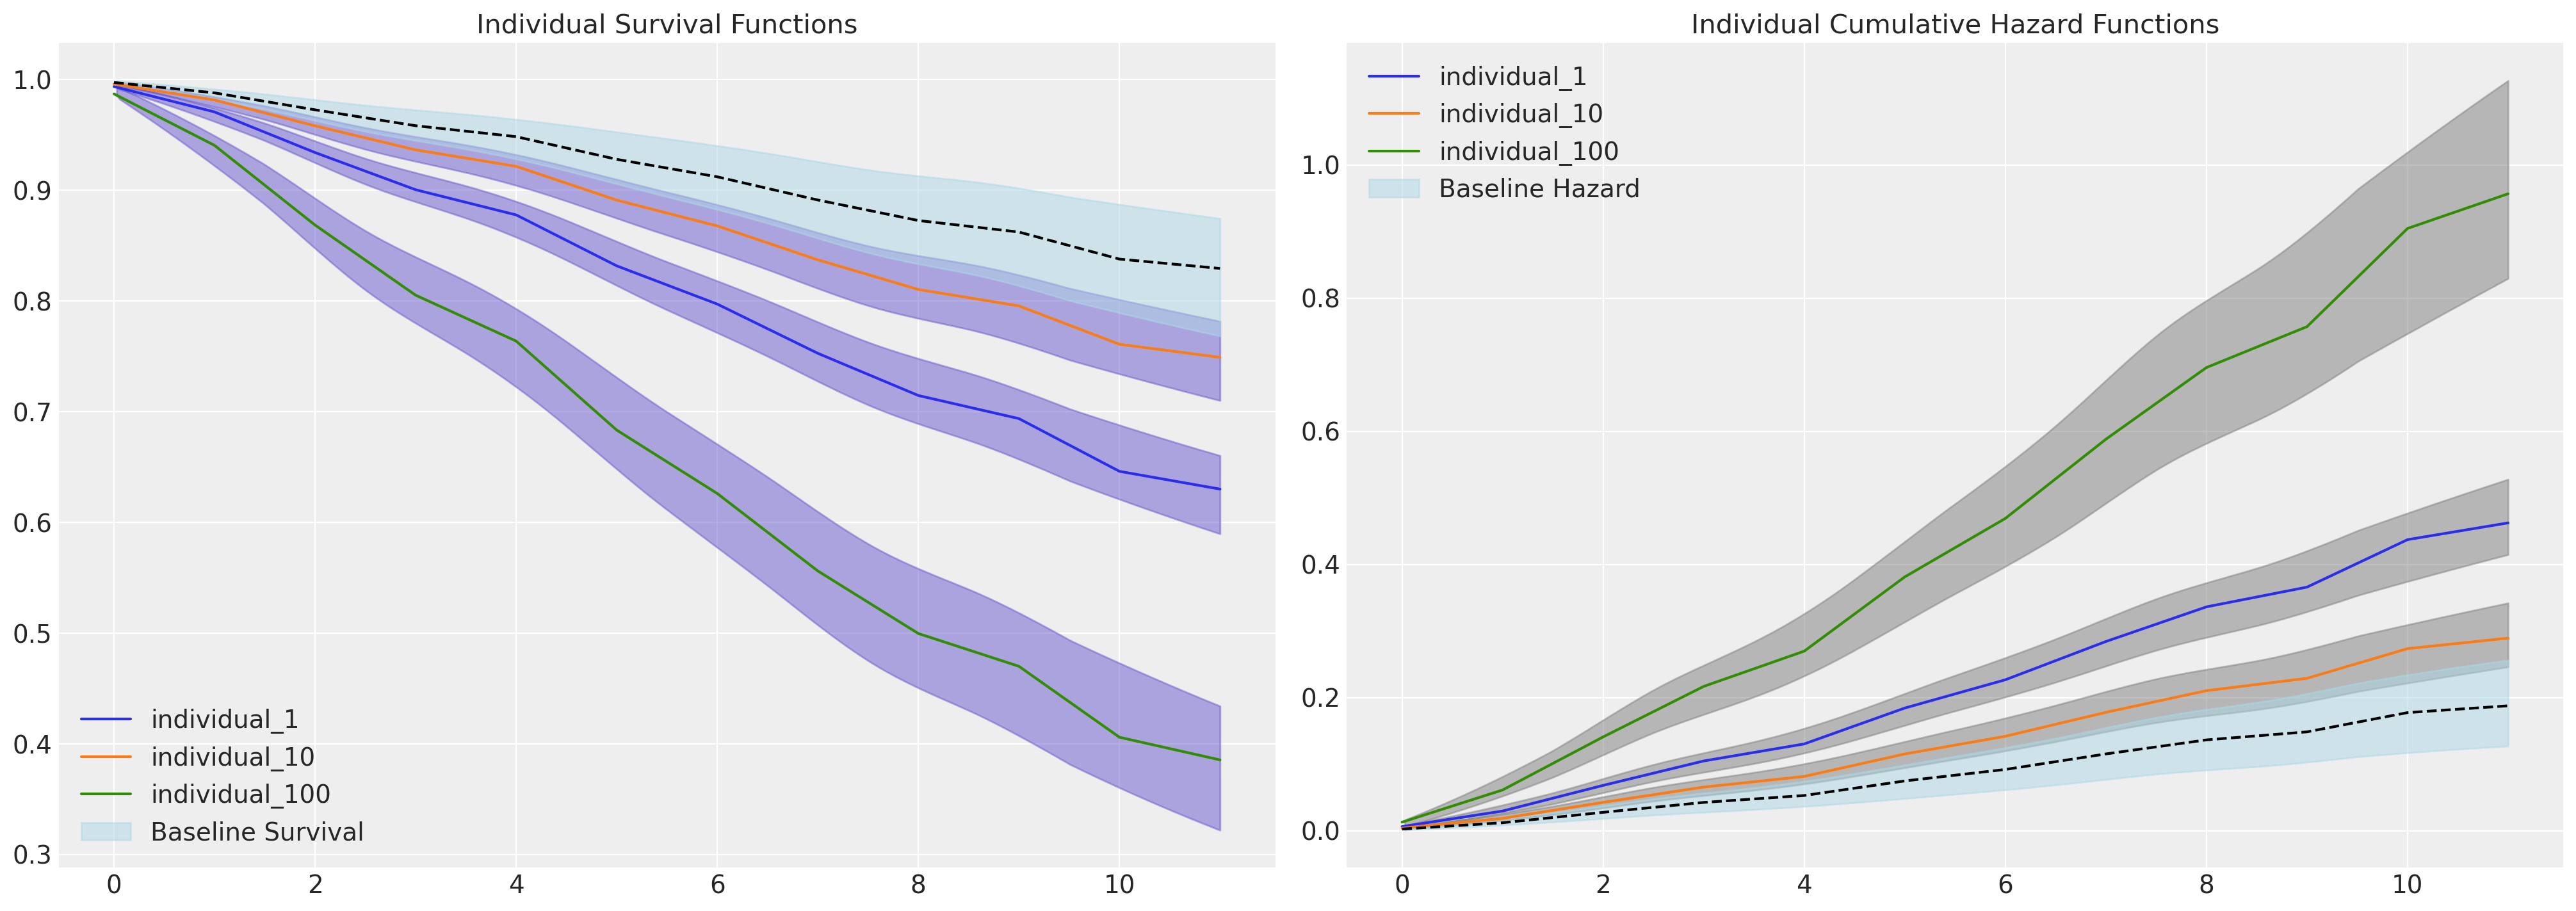

In [641]:
def extract_individual_hazard(i, retention_df):
    hazard_base_m1 = base_idata['posterior']['lambda0']
    beta = base_idata.posterior['beta']
    full_hazard_idata = hazard_base_m1 * np.exp(
                                        beta.sel(preds='sentiment')*retention_df.iloc[i]['sentiment'] + 
                                        beta.sel(preds='intention')*retention_df.iloc[i]['intention'] +
                                        beta.sel(preds='Male')*retention_df.iloc[i]['M'] +
                                        beta.sel(preds='Low')*retention_df.iloc[i]['Low'] +  
                                        beta.sel(preds='Medium')*retention_df.iloc[i]['Medium'] +
                                        beta.sel(preds='Finance')*retention_df.iloc[i]['Finance'] +
                                        beta.sel(preds='Health')*retention_df.iloc[i]['Health'] +
                                        beta.sel(preds='Law')*retention_df.iloc[i]['Law'] +
                                        beta.sel(preds='Public/Government')*retention_df.iloc[i]['Public/Government'] +
                                        beta.sel(preds='Sales/Marketing')*retention_df.iloc[i]['Sales/Marketing'] 
                                        )

    cum_haz_idata = cum_hazard(full_hazard_idata)
    survival_idata = survival(full_hazard_idata)
    return full_hazard_idata, cum_haz_idata, survival_idata, hazard_base_m1


def plot_individuals(retention_df, individuals=[1, 10, 100]): 
    fig, axs = plt.subplots(1, 2, figsize=(20, 7))
    axs = axs.flatten()
    for i in individuals:
        haz_idata, cum_haz_idata, survival_idata, base_hazard = extract_individual_hazard(i, retention_df)
        axs[0].plot(get_mean(survival_idata), label=f'individual_{i}')
        az.plot_hdi(range(12),survival_idata, ax=axs[0], fill_kwargs={'color': 'slateblue'})
        axs[1].plot(get_mean(cum_haz_idata), label=f'individual_{i}')
        az.plot_hdi(range(12),cum_haz_idata, ax=axs[1], fill_kwargs={'color': 'grey'})
        axs[0].set_title("Individual Survival Functions", fontsize=15)
        axs[1].set_title("Individual Cumulative Hazard Functions", fontsize=15)
    az.plot_hdi(range(12), survival(base_hazard), color='lightblue', ax=axs[0], fill_kwargs={"label": "Baseline Survival"})
    axs[0].plot(get_mean(survival(base_hazard)), color='black', linestyle='--')
    az.plot_hdi(range(12), cum_hazard(base_hazard), color='lightblue', ax=axs[1], fill_kwargs={"label": "Baseline Hazard"})
    axs[1].plot(get_mean(cum_hazard(base_hazard)), color='black', linestyle='--')
    axs[0].legend()
    axs[1].legend()



plot_individuals(retention_df)



In [501]:
retention_df[retention_df.index.isin([1, 10, 100])]

gender                   field   level  sentiment  intention  left  month  \
1        F                 Finance     Low          8          4     0     12   
10       F  Education and Training  Medium          8          3     0     12   
100      M  Education and Training     Low          8          9     1      5   

     M  Low  Medium  Finance  Health  Law  Public/Government  Sales/Marketing  
1    0    1       0        1       0    0                  0                0  
10   0    0       1        0       0    0                  0                0  
100  1    1       0        0       0    0                  0                0

## Predicting Marginal Effects

In [642]:
test_df = pd.DataFrame(np.zeros((3, 15)), columns=retention_df.columns)
test_df['sentiment'] = [1, 5, 10]
test_df['Medium'] = [1, 1, 1]
test_df['Finance'] = [1, 1, 1]
test_df['M'] = [0, 0, 0]
test_df

gender  field  level  sentiment  intention  left  month  M  Low  Medium  \
0     0.0    0.0    0.0          1        0.0   0.0    0.0  0  0.0       1   
1     0.0    0.0    0.0          5        0.0   0.0    0.0  0  0.0       1   
2     0.0    0.0    0.0         10        0.0   0.0    0.0  0  0.0       1   

   Finance  Health  Law  Public/Government  Sales/Marketing  
0        1     0.0  0.0                0.0              0.0  
1        1     0.0  0.0                0.0              0.0  
2        1     0.0  0.0                0.0              0.0

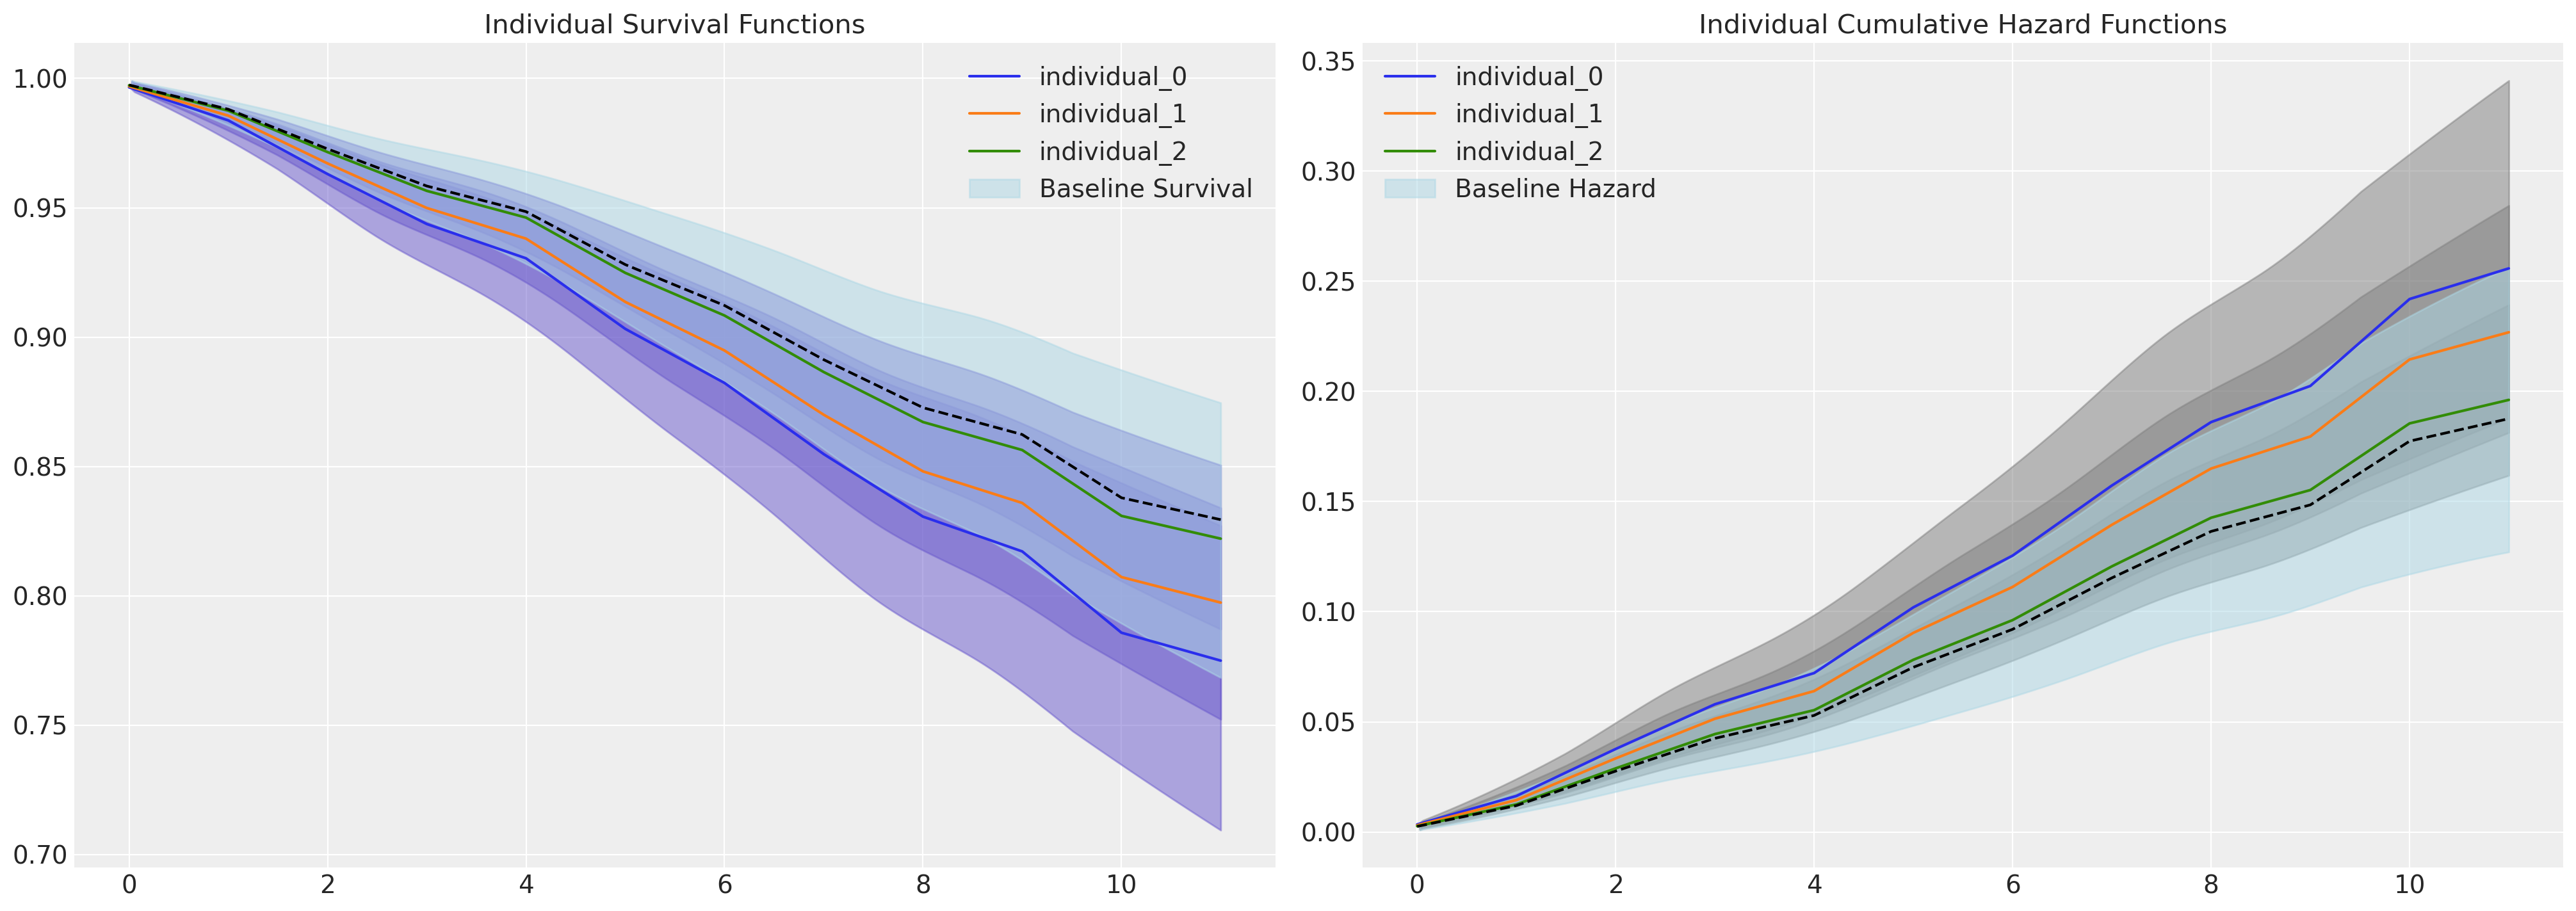

In [643]:
plot_individuals(test_df, [0, 1, 2])

In [477]:
def create_predictions(retention_df):
    cum_haz = {}
    surv = {}
    for i in range(len(retention_df)):
        haz_idata, cum_haz_idata, survival_idata, base_hazard = extract_individual_hazard(i, retention_df)
        cum_haz[i] = get_mean(cum_haz_idata)
        surv[i] = get_mean(survival_idata)
    cum_haz = pd.DataFrame(cum_haz)
    surv = pd.DataFrame(surv)
    return cum_haz, surv

cum_haz_df, surv_df = create_predictions(retention_df)
cum_haz_df.head()

0         1         2         3         4         5         6     \
0  0.011986  0.006235  0.008686  0.006322  0.008178  0.019908  0.003275   
1  0.056843  0.029588  0.041188  0.029998  0.038797  0.094333  0.015531   
2  0.130860  0.068116  0.094815  0.069055  0.089314  0.217211  0.035754   
3  0.201299  0.104772  0.145847  0.106218  0.137385  0.334130  0.054999   
4  0.250494  0.130381  0.181494  0.132180  0.170966  0.415788  0.068442   

       7         8         9     ...      3760      3761      3762      3763  \
0  0.016798  0.007303  0.005602  ...  0.004735  0.002526  0.012568  0.011489   
1  0.079701  0.034630  0.026586  ...  0.022456  0.011980  0.059599  0.054510   
2  0.183460  0.079723  0.061213  ...  0.051704  0.027580  0.137237  0.125478   
3  0.282183  0.122637  0.094164  ...  0.079530  0.042425  0.211100  0.193002   
4  0.351157  0.152609  0.117177  ...  0.098970  0.052795  0.262705  0.240176   

       3764      3765      3766      3767      3768      3769  
0  0.011272  0.002937  0.009503  0.008578  0.003798  0.004671  
1  0.053411  0.013930  0.045092  0.040707  0.018010  0.022153  
2  0.122968  0.032074  0.103799  0.093711  0.041460  0.050997  
3  0.189153  0.049337  0.159658  0.144143  0.063780  0.078445  
4  0.235375  0.061397  0.198681  0.179372  0.079368  0.097615  

[5 rows x 3770 columns]

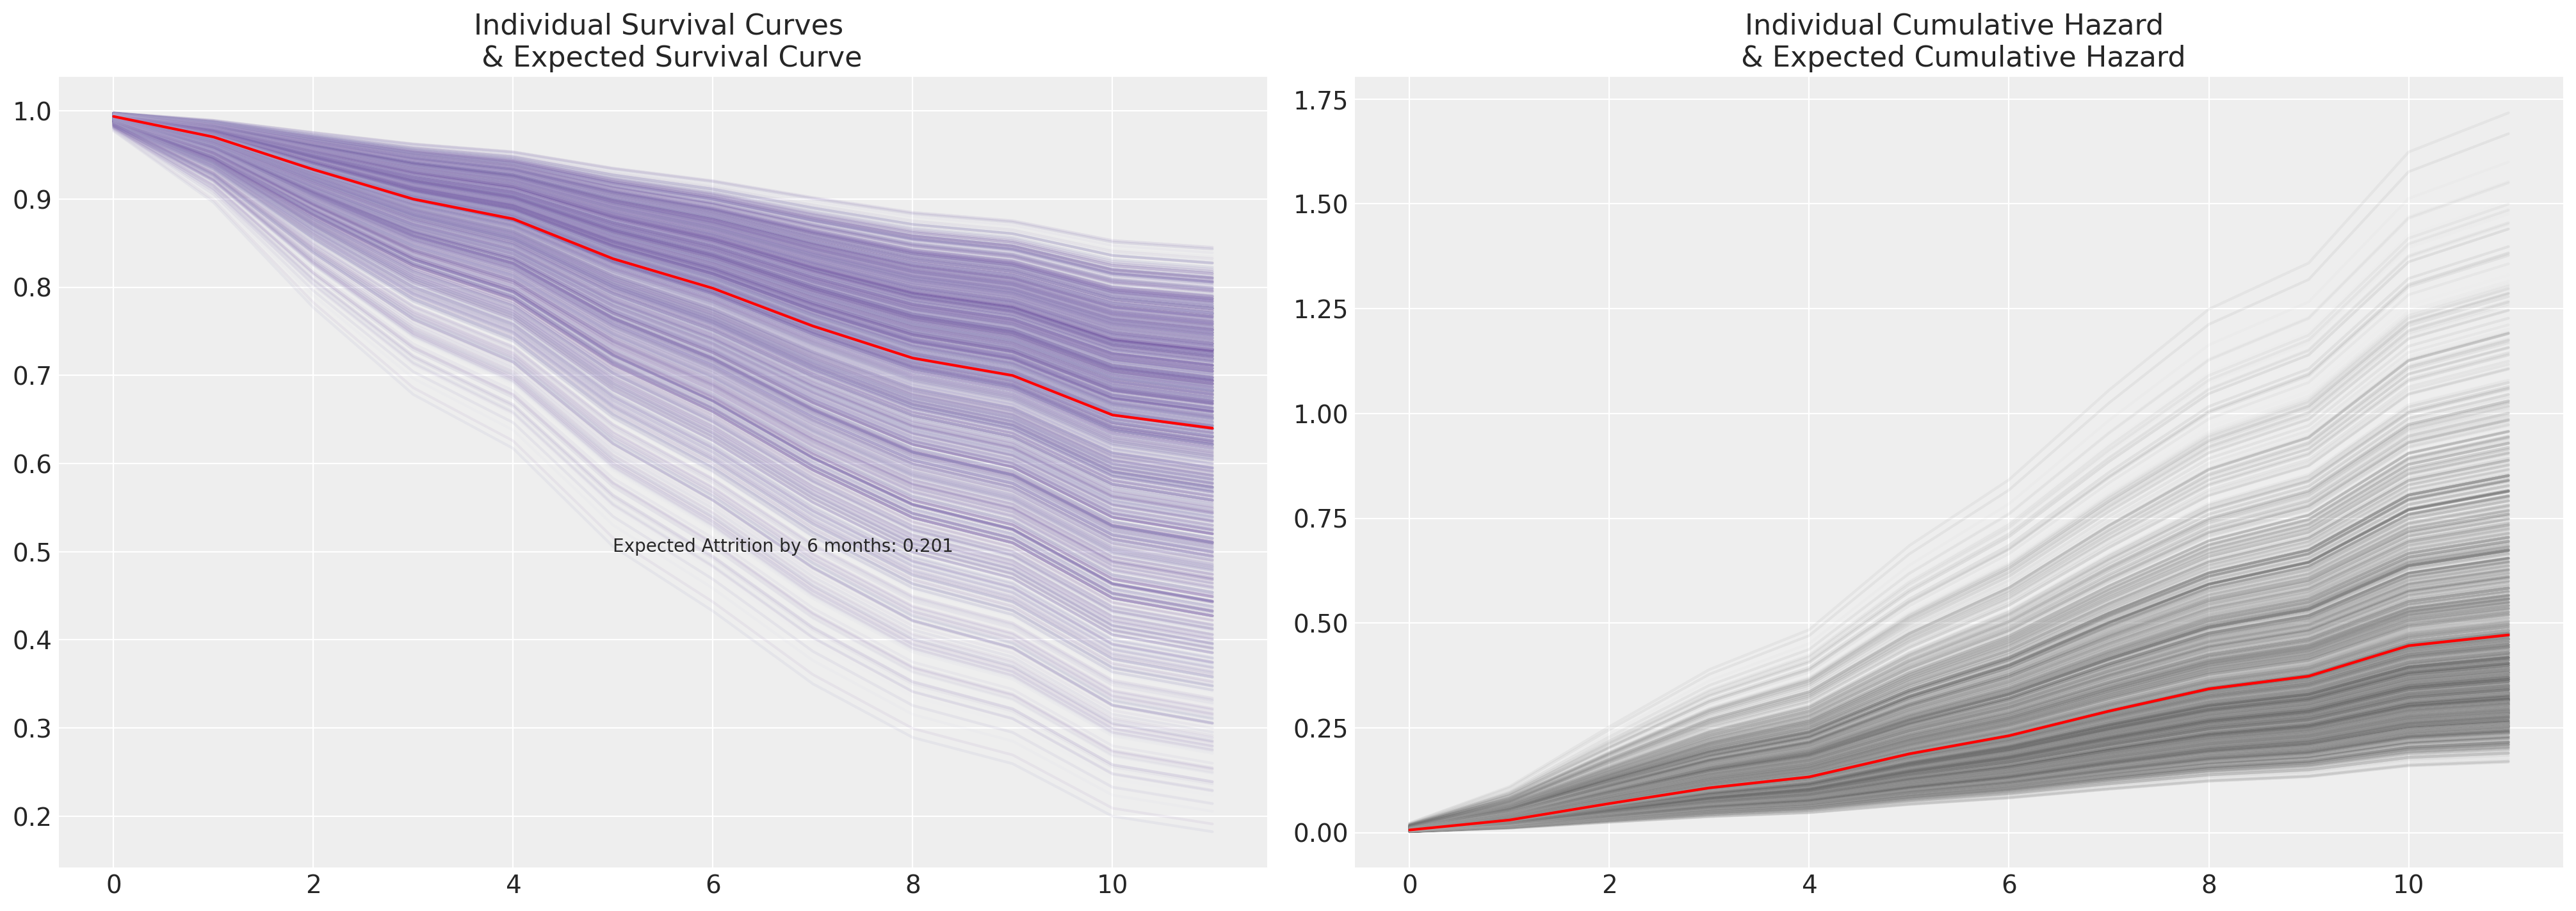

In [647]:
cm_subsection = np.linspace(0, 1, 120) 
colors_m = [cm.Purples(x) for x in cm_subsection]
colors = [cm.Greys(x) for x in cm_subsection]


fig, axs = plt.subplots(1, 2, figsize=(20, 7))
axs = axs.flatten()
cum_haz_df.plot(legend=False, color=colors, alpha=0.05, ax=axs[1])
axs[1].plot(cum_haz_df.mean(axis=1), color='red')
axs[1].set_title("Individual Cumulative Hazard \n & Expected Cumulative Hazard")

surv_df.plot(legend=False, color=colors_m, alpha=0.05, ax=axs[0])
axs[0].plot(surv_df.mean(axis=1), color='red');
axs[0].set_title("Individual Survival Curves \n  & Expected Survival Curve");
axs[0].annotate(f'Expected Attrition by 6 months: {np.round(1-surv_df.mean(axis=1).iloc[6], 3)}', (5, 0.5));

## Interrogating Frailty Models


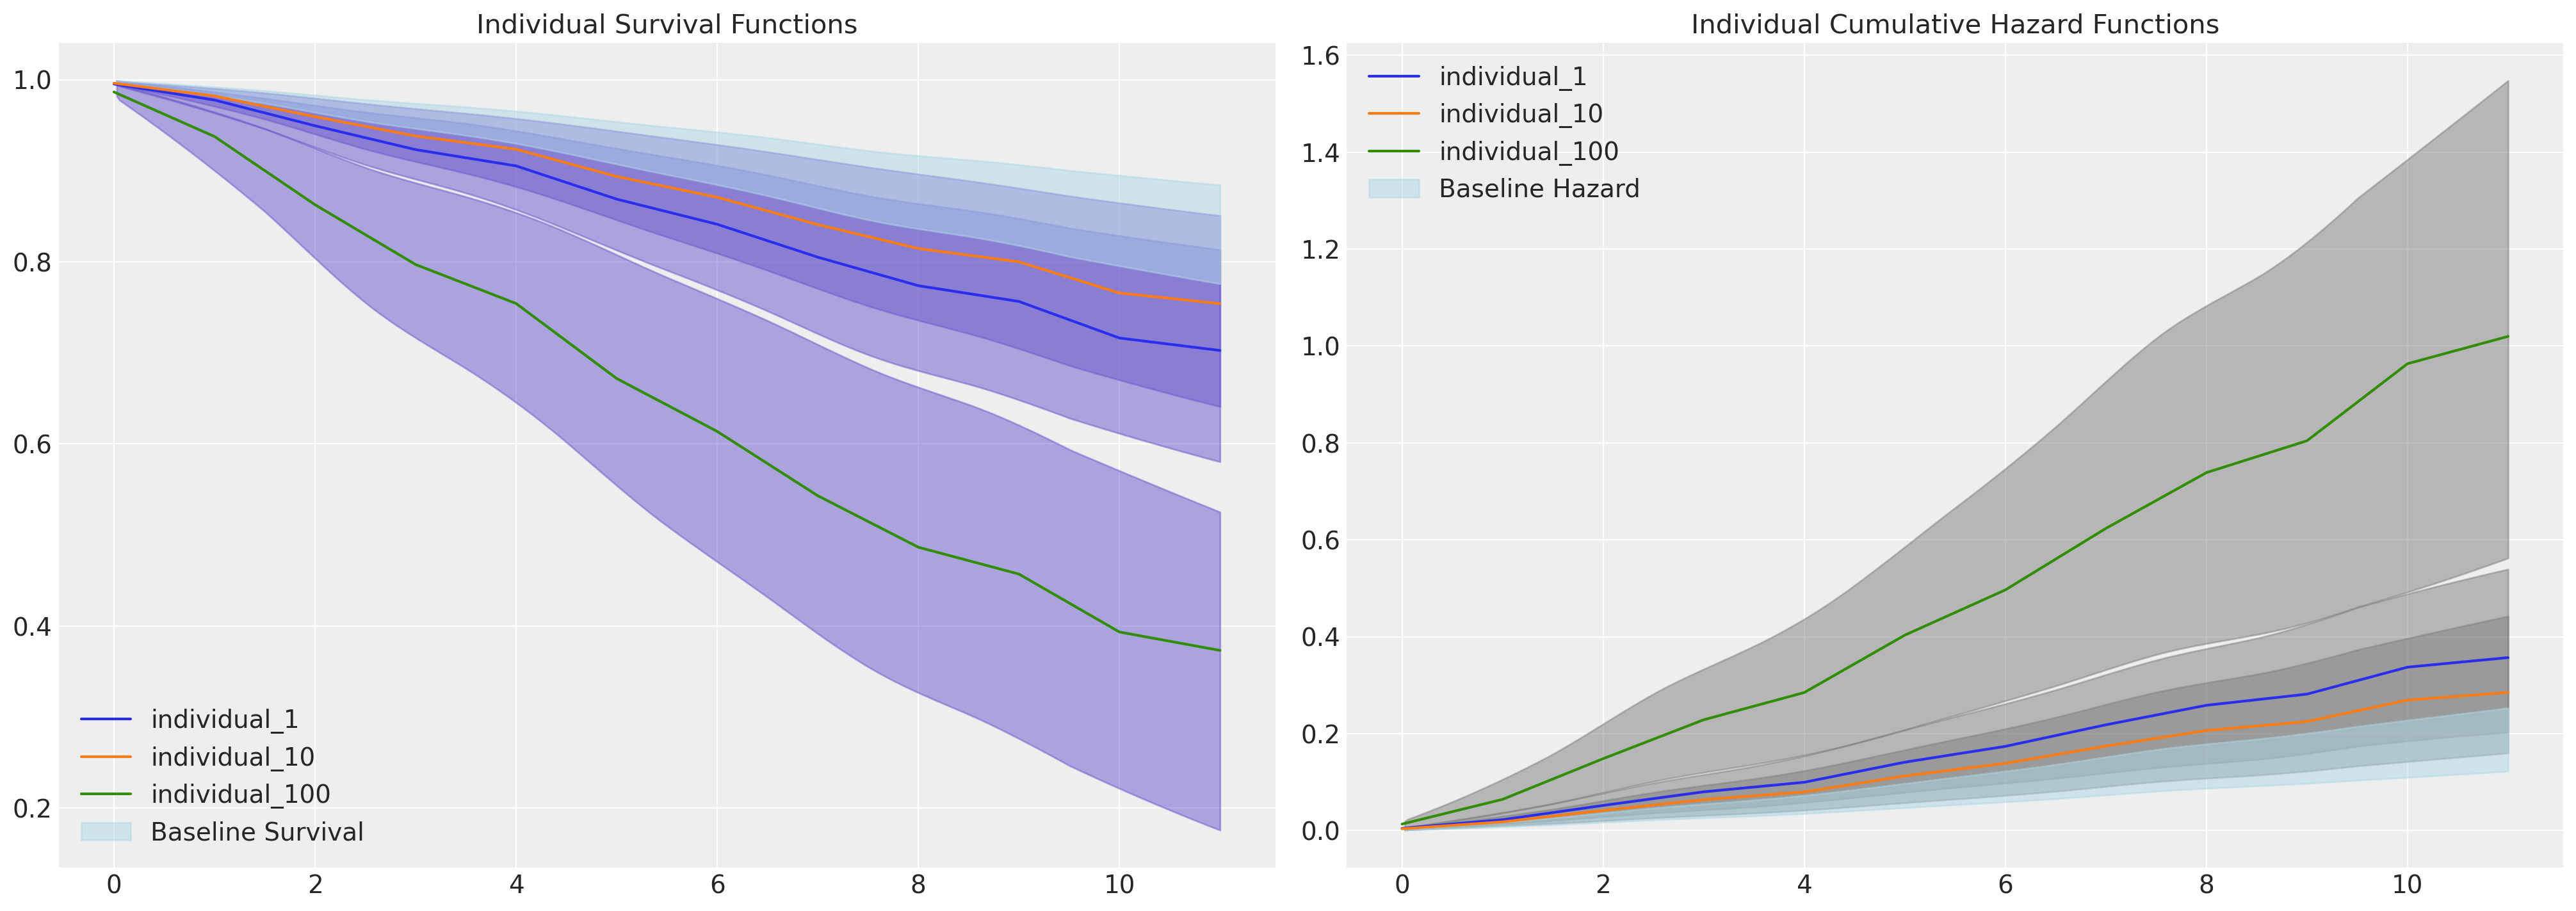

In [640]:
def extract_individual_frailty(i, retention_df):
    hazard_base = frailty_idata['posterior']['lambda0']
    beta = frailty_idata.posterior['beta']
    frailty = frailty_idata.posterior['frailty']
    full_hazard_idata = frailty.sel(frailty_id=i)*(hazard_base * np.exp( 
                                        beta.sel(preds='sentiment')*retention_df.iloc[i]['sentiment'] + 
                                        beta.sel(preds='intention')*retention_df.iloc[i]['intention'] +
                                        beta.sel(preds='Male')*retention_df.iloc[i]['M'] +
                                        beta.sel(preds='Low')*retention_df.iloc[i]['Low'] +  
                                        beta.sel(preds='Medium')*retention_df.iloc[i]['Medium'] 
                                        ))

    cum_haz_idata = cum_hazard(full_hazard_idata)
    survival_idata = survival(full_hazard_idata)
    return full_hazard_idata, cum_haz_idata, survival_idata, hazard_base

def plot_individual_frailty(retention_df, individuals=[1, 10, 100]): 
    fig, axs = plt.subplots(1, 2, figsize=(20, 7))
    axs = axs.flatten()
    for i in individuals:
        haz_idata, cum_haz_idata, survival_idata, base_hazard = extract_individual_frailty(i, retention_df)
        axs[0].plot(get_mean(survival_idata), label=f'individual_{i}')
        az.plot_hdi(range(12),survival_idata, ax=axs[0], fill_kwargs={'color': 'slateblue'})
        axs[1].plot(get_mean(cum_haz_idata), label=f'individual_{i}')
        az.plot_hdi(range(12),cum_haz_idata, ax=axs[1], fill_kwargs={'color': 'grey'})
        axs[0].set_title("Individual Survival Functions", fontsize=15)
        axs[1].set_title("Individual Cumulative Hazard Functions", fontsize=15)
    az.plot_hdi(range(12), survival(base_hazard), color='lightblue', ax=axs[0], fill_kwargs={"label": "Baseline Survival"})
    az.plot_hdi(range(12), cum_hazard(base_hazard), color='lightblue', ax=axs[1], fill_kwargs={"label": "Baseline Hazard"})
    axs[0].legend()
    axs[1].legend()

plot_individual_frailty(retention_df)

In [457]:
def create_predictions(retention_df):
    cum_haz = {}
    surv = {}
    for i in range(len(retention_df)):
        haz_idata, cum_haz_idata, survival_idata, base_hazard = extract_individual_frailty(i, retention_df)
        cum_haz[i] = get_mean(cum_haz_idata)
        surv[i] = get_mean(survival_idata)
    cum_haz = pd.DataFrame(cum_haz)
    surv = pd.DataFrame(surv)
    return cum_haz, surv

cum_haz_frailty_df, surv_frailty_df = create_predictions()
cum_haz_frailty_df.head()

0         1         2         3         4         5         6     \
0  0.011385  0.004754  0.009111  0.004830  0.006866  0.016564  0.003172   
1  0.054132  0.022603  0.043338  0.023006  0.032700  0.078765  0.015103   
2  0.124505  0.051998  0.099676  0.052938  0.075227  0.181145  0.034732   
3  0.191745  0.080102  0.153521  0.081531  0.115906  0.278955  0.053491   
4  0.238893  0.099793  0.191240  0.101583  0.144417  0.347554  0.066637   

       7         8         9     ...      3760      3761      3762      3763  \
0  0.012445  0.006777  0.005010  ...  0.004487  0.002447  0.010732  0.008611   
1  0.059193  0.032261  0.023886  ...  0.021336  0.011635  0.051085  0.041010   
2  0.136118  0.074213  0.054948  ...  0.049097  0.026760  0.117529  0.094303   
3  0.209645  0.114319  0.084608  ...  0.075621  0.041217  0.180998  0.145304   
4  0.261189  0.142417  0.105413  ...  0.094215  0.051355  0.225468  0.181049   

       3764      3765      3766      3767      3768      3769  
0  0.008972  0.002573  0.007758  0.006999  0.003258  0.004012  
1  0.042759  0.012241  0.036924  0.033301  0.015527  0.019099  
2  0.098395  0.028156  0.084911  0.076580  0.035706  0.043928  
3  0.151543  0.043363  0.130766  0.117937  0.055000  0.067661  
4  0.188789  0.054021  0.162908  0.146961  0.068510  0.084277  

[5 rows x 3770 columns]

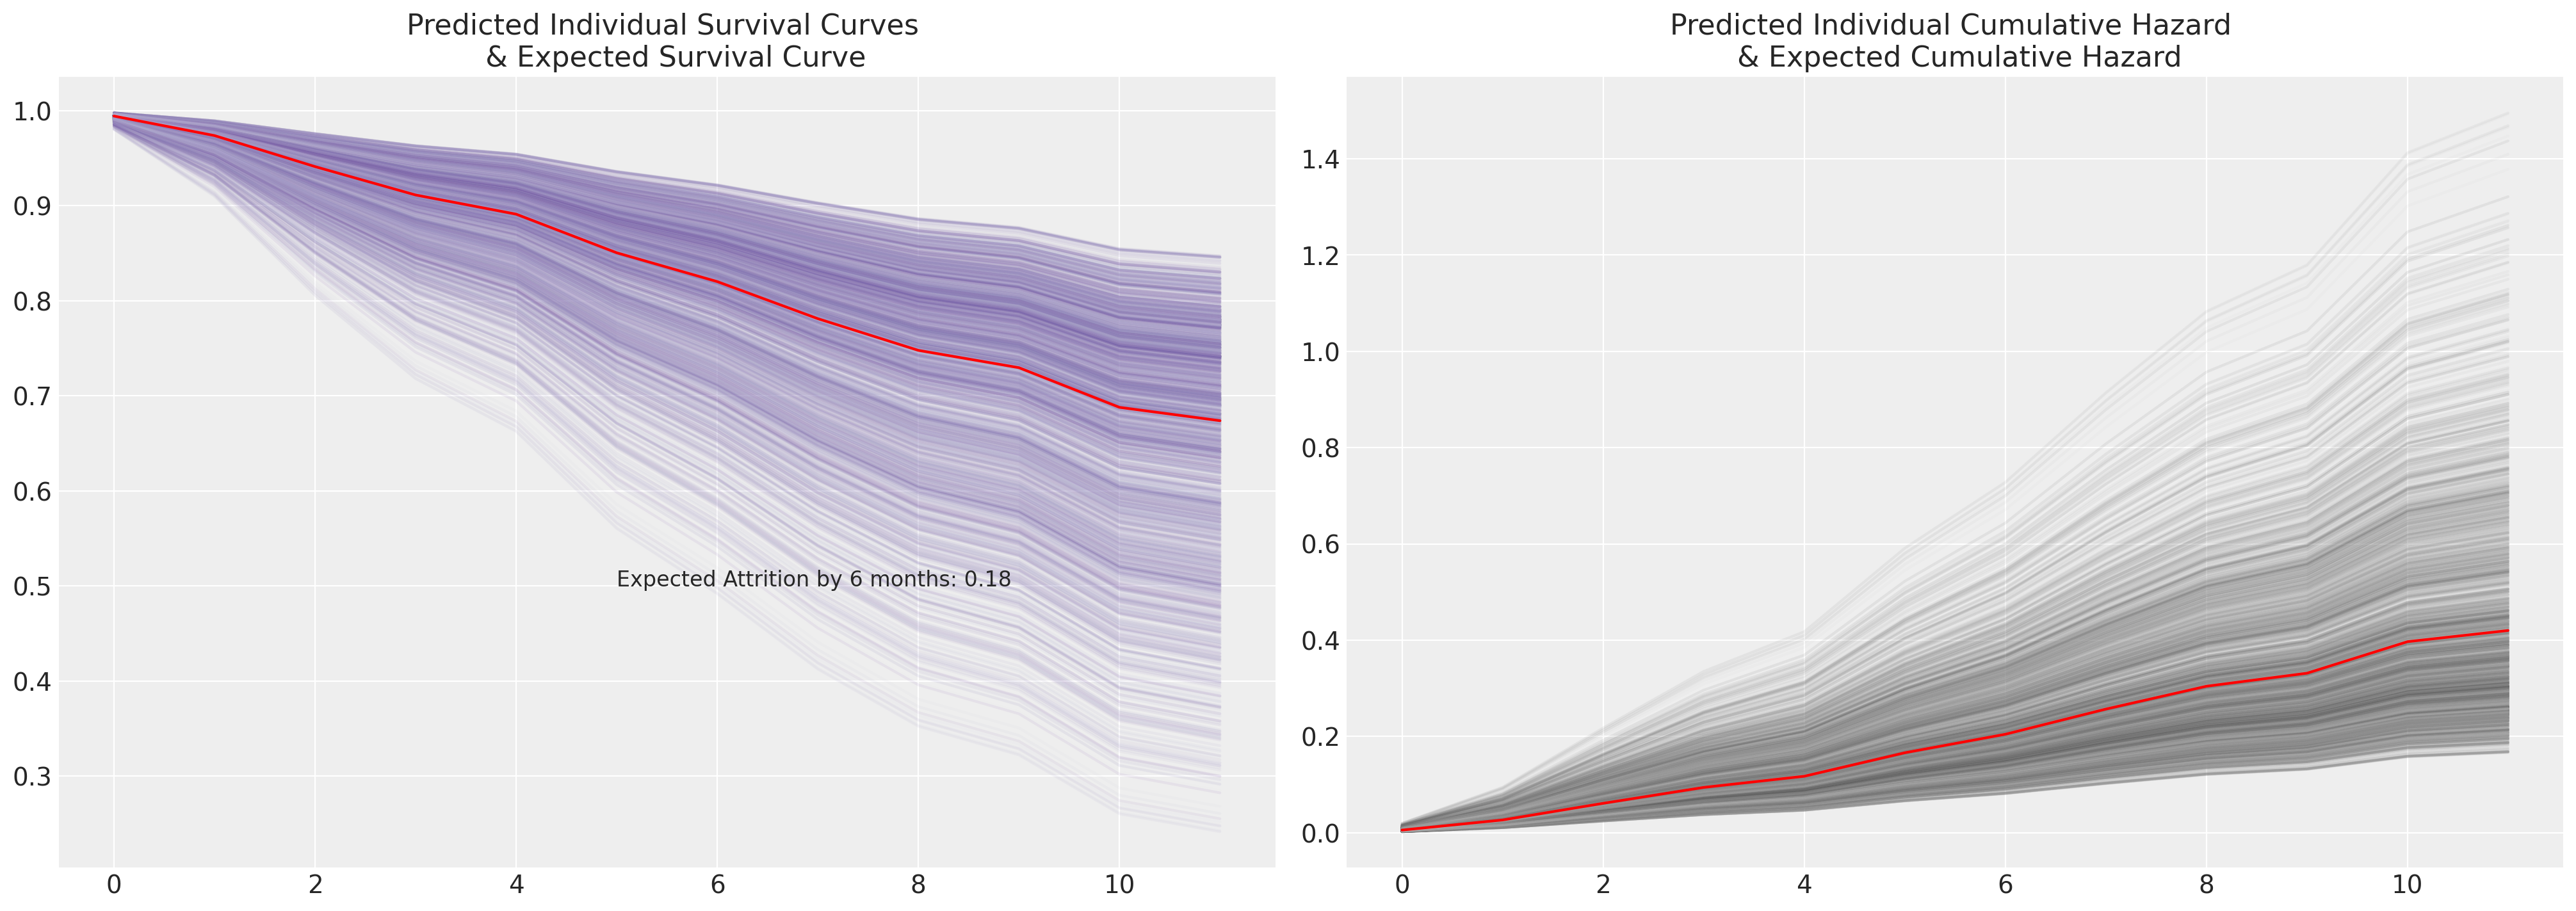

In [648]:
cm_subsection = np.linspace(0, 1, 120) 
colors_m = [cm.Purples(x) for x in cm_subsection]
colors = [cm.Greys(x) for x in cm_subsection]


fig, axs = plt.subplots(1, 2, figsize=(20, 7))
axs = axs.flatten()
cum_haz_frailty_df.plot(legend=False, color=colors, alpha=0.05, ax=axs[1])
axs[1].plot(cum_haz_frailty_df.mean(axis=1), color='red')
axs[1].set_title("Predicted Individual Cumulative Hazard \n & Expected Cumulative Hazard")

surv_frailty_df.plot(legend=False, color=colors_m, alpha=0.05, ax=axs[0])
axs[0].plot(surv_frailty_df.mean(axis=1), color='red');
axs[0].set_title("Predicted Individual Survival Curves \n  & Expected Survival Curve");
axs[0].annotate(f'Expected Attrition by 6 months: {np.round(1-surv_frailty_df.mean(axis=1).iloc[6], 3)}', (5, 0.5), fontsize=12);

In [654]:
beta_individual = frailty_idata["posterior"]["frailty"]
beta_individual = beta_individual.sel(frailty_id=range(120))
predicted = beta_individual.mean(("chain", "draw"))
predicted = predicted.sortby(predicted)
ci_lb = beta_individual.quantile(0.025, ("chain", "draw")).sortby(predicted)
ci_ub = beta_individual.quantile(0.975, ("chain", "draw")).sortby(predicted)
hdi = az.hdi(beta_individual, hdi_prob=0.5).sortby(predicted)
hdi2 = az.hdi(beta_individual, hdi_prob=0.85).sortby(predicted)

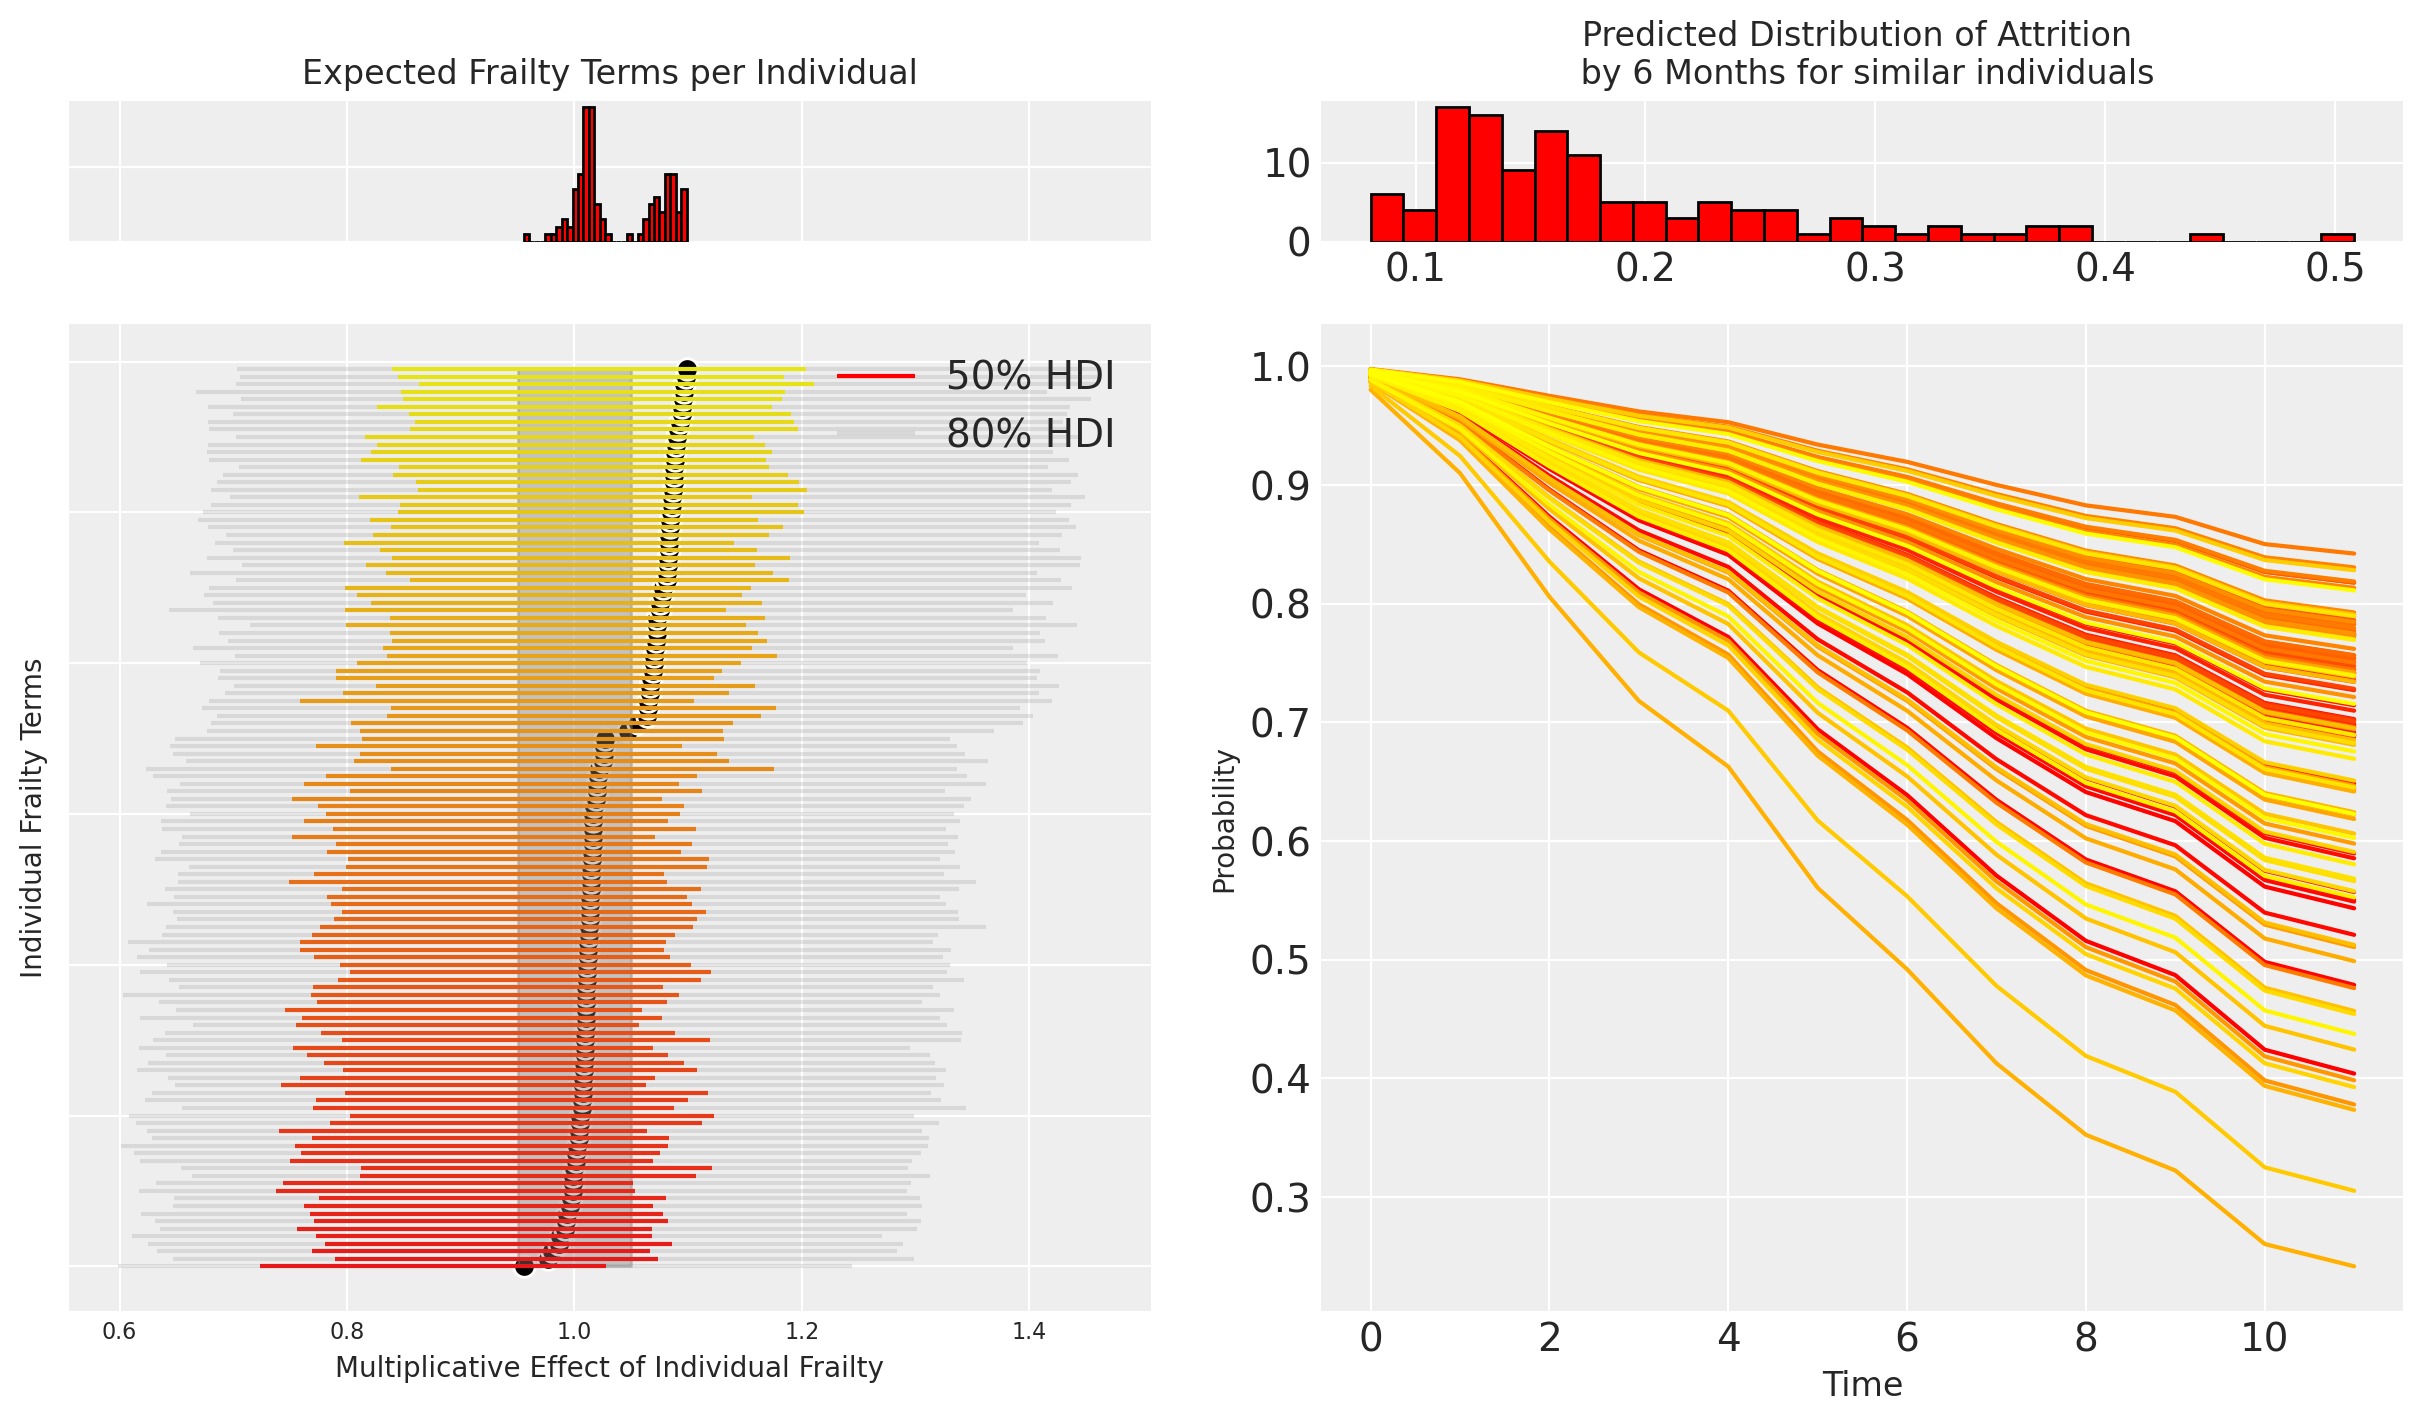

In [663]:
cm_subsection = np.linspace(0, 1, 120) 
colors = [cm.autumn(x) for x in cm_subsection]

fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(
    2,
    2,
    height_ratios=(1, 7),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.05,
    hspace=0.05,
)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax.set_yticklabels([])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histx.set_title("Expected Frailty Terms per Individual", fontsize=12)
ax_histx.hist(predicted, bins=30, ec="black", color='red')
ax_histx.set_yticklabels([])
ax_histx.tick_params(labelsize=8)
ax.set_ylabel("Individual Frailty Terms", fontsize=10)
ax.tick_params(labelsize=8)
ax.hlines(
    range(len(predicted)),
    hdi.sel(hdi='lower').to_array(),
    hdi.sel(hdi='higher').to_array(),
    color=colors,
    label='50% HDI'
)
ax.hlines(
    range(len(predicted)),
    hdi2.sel(hdi='lower').to_array(),
    hdi2.sel(hdi='higher').to_array(),
    color='grey',
    alpha=0.2, 
    label='80% HDI'
)
ax.scatter(predicted, range(len(predicted)), color="black", ec="white", s=60)
ax.set_xlabel("Multiplicative Effect of Individual Frailty", fontsize=10)
ax.legend()
ax.fill_betweenx(range(len(predicted)), 0.95, 1.05, alpha=0.4, color="grey");

ax1 = fig.add_subplot(gs[1, 1])
surv_frailty_df[list(predicted['frailty_id'].values)].plot(ax=ax1, legend=False, color=colors);
ax1_hist = fig.add_subplot(gs[0, 1])
ax1_hist.hist((1 - surv_frailty_df[list(predicted['frailty_id'].values)].iloc[6]), bins=30, color='red', ec='black')
ax1.set_xlabel("Time", fontsize=12)
ax1_hist.set_title("Predicted Distribution of Attrition \n by 6 Months for similar individuals", fontsize=12);
ax1.set_ylabel('Probability', fontsize=10);


In [695]:
retention_df['estimated_frailty'] = frailty_idata["posterior"]["frailty"].mean(("chain", "draw"))
(retention_df.groupby(['gender', 'level', 'field', 'intention'])[['estimated_frailty']].median().reset_index()
 .pivot(['gender', 'level', 'field'], 'intention', 'estimated_frailty')
 ).style.background_gradient(cmap='OrRd')

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_69112/1609500481.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  (retention_df.groupby(['gender', 'level', 'field', 'intention'])[['estimated_frailty']].median().reset_index()


## Comparing the Model Implications

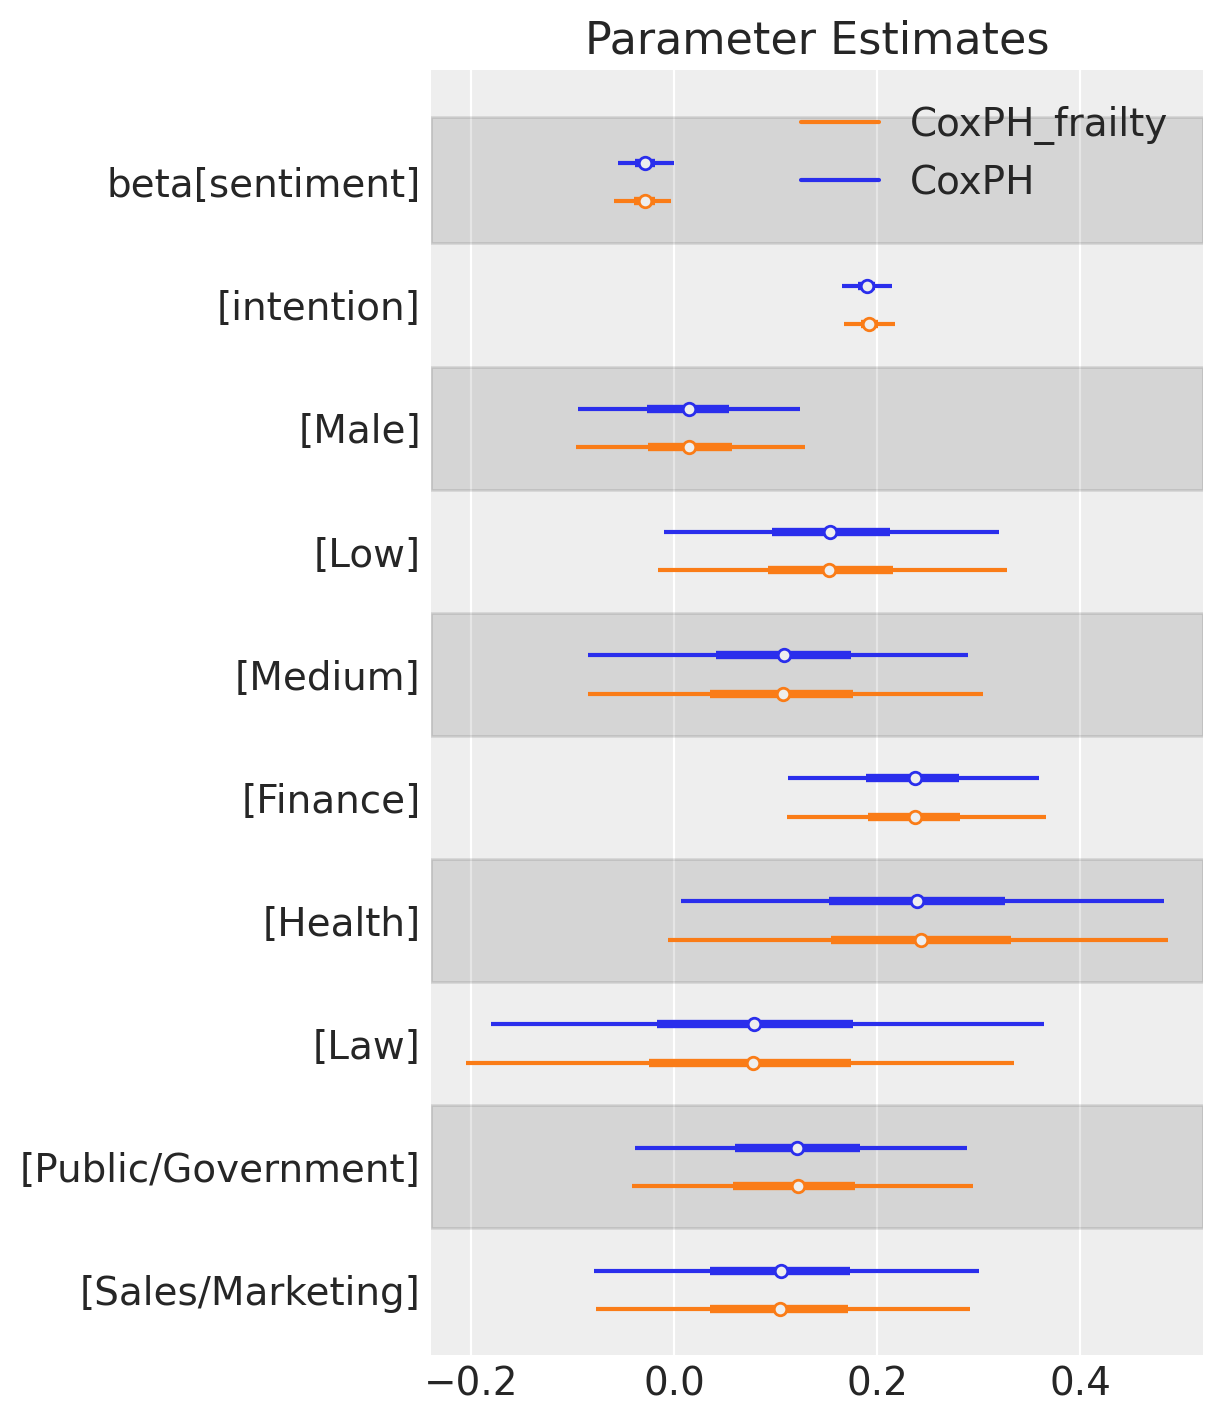

In [511]:
ax = az.plot_forest([base_idata, frailty_idata], var_names=['beta'], combined=True, model_names=['CoxPH', 'CoxPH_frailty'])
ax[0].set_title("Parameter Estimates");

0.17975611292210547
0.2012819253347755


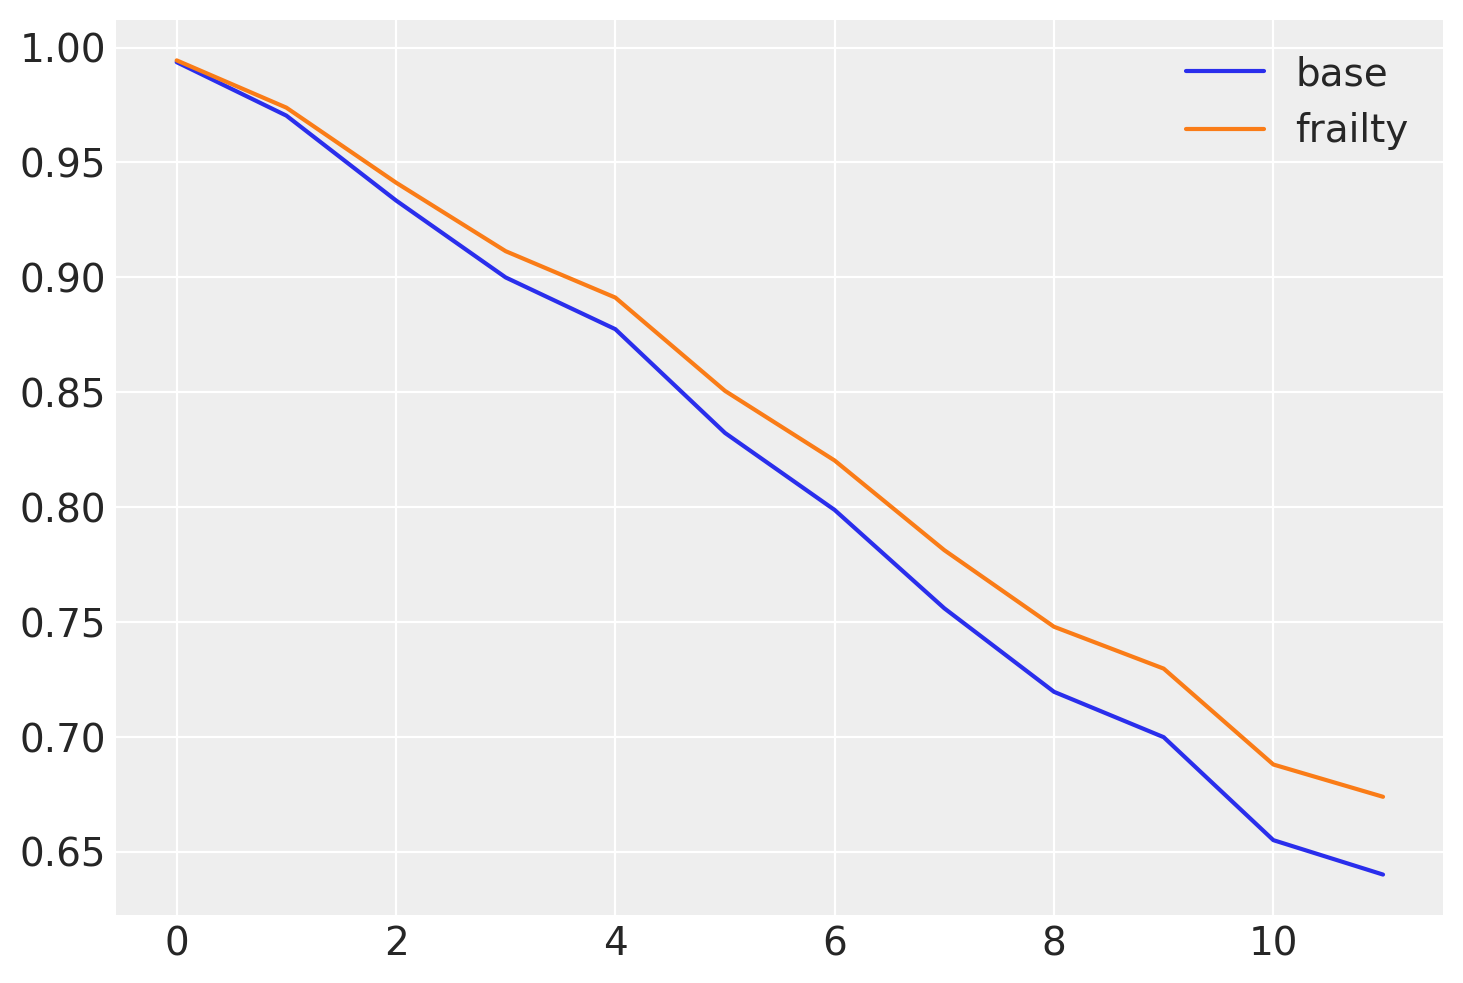

In [469]:
fig, ax = plt.subplots()
ax.plot(surv_df.mean(axis=1), label='base')
ax.plot(surv_frailty_df.mean(axis=1), label='frailty')
ax.legend()
print(1-surv_frailty_df.mean(axis=1).iloc[6])
print(1-surv_df.mean(axis=1).iloc[6])


## Authors
- Authored by [Nathaniel Forde](https://nathanielf.github.io/) in July 2023 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [4]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed Jun 21 2023

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.11.0

pytensor: 2.11.1

numpy     : 1.23.5
matplotlib: 3.7.1
pandas    : 1.5.3
pymc      : 5.3.0
arviz     : 0.15.1

Watermark: 2.3.1



:::{include} ../page_footer.md
:::